In [1]:
%matplotlib widget
import numpy as np
import json, copy
import os, math, glob
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats.stats import pearsonr
from IPython.display import clear_output, display
from ipyfilechooser import FileChooser

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *

from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

## choose file either with the run number (first cell) or widget (second cell)

In [219]:
pgroup='p20774'
runnumber = 293
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
jsonfile

run: 0293


'/sf/alvra/data/p20774/raw/run0293-RuRh_ClK_powerscan_2819p7eV_001/meta/scan.json'

In [220]:
#fc = FileChooser('/sf/alvra/data/p20269/raw')
#fc.use_dir_icons = True
#display(fc)

In [221]:
#jsonfile = copy.copy(fc.selected)
#jsonfile

In [222]:
quantile_corr = 0.5

detector_XAS = channel_diode_2
detector_Izero = channel_Izero122

reducedir='../Claudio/Reduced_fluencescan/'

#######################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

(DataDiode_pump, DataDiode_unpump, Pump_probe_Diode,Izero_pump, Izero_unpump, correlation, waveplate, goodshots) = \
XAS_scan_1diode(scan, detector_XAS, detector_Izero, quantile_corr)

run_name = jsonfile.split('/')[-3]
os.makedirs(reducedir+run_name, exist_ok=True)

save_data_XANES(reducedir, run_name, waveplate, 
                DataDiode_pump, DataDiode_unpump, Pump_probe_Diode, goodshots)


Processing: run0293-RuRh_ClK_powerscan_2819p7eV_001
Step 10 of 10: Processing acq0010

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 495 pump and 495 unpump shots
(125,) shots out of (495,) survived
Step 10 of 10: Processed acq0010
correlation Diode (all shots) = 0.9970394001627282
------------------------------
Processed 10 out of 10 files


In [223]:
#[2.40744133e+02 1.67279498e-01 4.07745686e+01]
#waveplate2 = 0.12612736 + 66.03399024*(np.cos(np.pi/180.*(waveplate - 60.29428308)))**2

#[2.40744133e+02 1.67279498e-01 4.07745686e+01]
#waveplate2 = 0.167279498 + 40.7745686*(np.cos(np.pi/180.*(waveplate - 240.744133)))**2    ##calibration from 3.12 in the night
#waveplate2 = 0 + 44.82*(np.cos(np.pi/180.*(waveplate - 277.63)))**2    ##calibration from 3.12 in the night

#yscale = 8.16083889
#xshift = 91.2282651 

#params = [-1.17278977e-05,  6.57499993e-03, -1.24567847e+00,  8.02365598e+01]
params = [ 3.14281178e-05, -2.86261544e-02,  9.84475847e+00, -1.51870990e+03, 8.89465859e+04] # from calibration of 30.1.2023

p = np.poly1d(params)

#intensity = waveplate 
intensity = p(waveplate)                                                              ## pulse energy (in uJ)
#intensity = p2 + p3*(2*np.cos(np.pi/180.*(waveplate + p1)))**2                       ## pulse energy (in uJ)
#intensity = yscale*(2*np.cos(np.pi/180.*(waveplate - xshift)))**2
#intensity = (p2 + p3*(np.cos(2*np.pi/180.*(waveplate - p1)))**2 )*1e-3/(2.45*1e-5)   ## fluence (in mJ/cm2)

# Plot Fluence scan

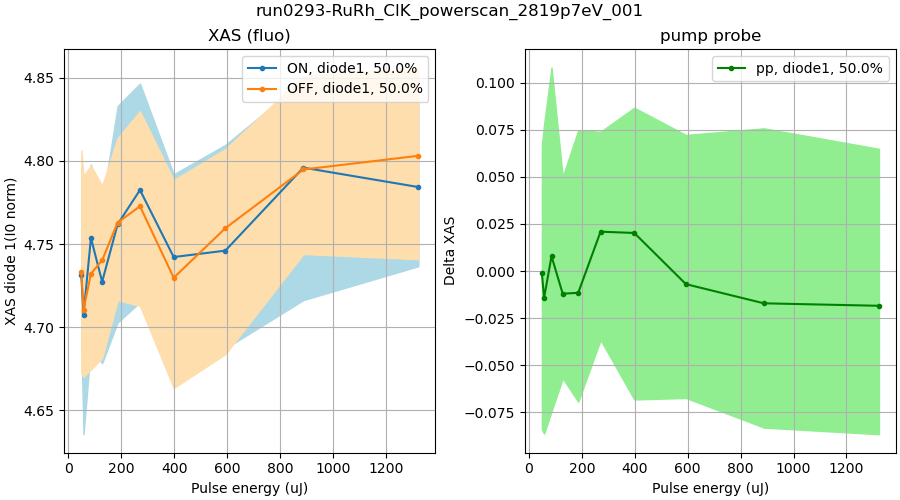

In [224]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-3], fontsize = 12)

XAS_pump = DataDiode_pump[:,0]
err_low_pump = DataDiode_pump[:,1]
err_high_pump = DataDiode_pump[:,2]
XAS_unpump = DataDiode_unpump[:,0]
err_low_unpump = DataDiode_unpump[:,1]
err_high_unpump = DataDiode_unpump[:,2]
XAS_pump_probe = Pump_probe_Diode[:,0]
err_low_pump_probe = Pump_probe_Diode[:,1]
err_high_pump_probe = Pump_probe_Diode[:,2]

ax1.plot(intensity, XAS_pump, label='ON, diode1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(intensity, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(intensity, XAS_unpump, label='OFF, diode1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(intensity, err_low_unpump, err_high_unpump, color='navajowhite')

ax1.set_xlabel("Pulse energy (uJ)")
#ax1.set_xlabel("Fluence (mJ/cm2)")
ax1.set_ylabel ("XAS diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(intensity, XAS_pump_probe, label='pp, diode1, {}%'.format(quantile_corr*100),marker='.', color = 'g')
ax2.fill_between(intensity, err_low_pump_probe, err_high_pump_probe, color='lightgreen')
#ax2.axes.errorbar(intensity, XAS_pump_probe, (XAS_pump_probe-err_low_pump_probe), (err_high_pump_probe-XAS_pump_probe), 
            # lw=1,color='green', markersize=0,capsize=3,capthick=1,
            #      ecolor='green',elinewidth=1)

ax2.set_xlabel("Pulse energy (uJ)")
#ax2.set_xlabel("Fluence (mJ/cm2)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

# load data

In [241]:
runlist = np.arange(283, 294, 1)
#runlist = [173, 174, 175, 177, 178]
Loaddir = '../Claudio/Reduced_fluencescan/'
##############################################
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))

Will load 11 runs: [283 284 285 286 287 288 289 290 291 292 293] from ../Claudio/Reduced_fluencescan/


In [242]:
from itertools import chain
datafiles = []
print (runlist)
for run in runlist:
    file = glob.glob(Loaddir + '/*{:04d}*/*XANES*npy*'.format(run))
    datafiles.append(file)
datafiles = itertools.chain.from_iterable(datafiles)
datafiles = sorted(datafiles, key = os.path.getmtime)
print ('{} files found'.format(len(datafiles)))
#datafiles  

[283 284 285 286 287 288 289 290 291 292 293]
55 files found


# Average the data

In [243]:
diode_array = ['XANES_DataDiode1_pump', 'XANES_DataDiode1_unpump', 'XANES_Pump_probe_Diode1']
goodshots_array = ['XANES_goodshots1']

for file in glob.glob(Loaddir+'XANES*.npy'):
    os.remove(file)
    
for spec in diode_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,spec))
        datafiles.append(file)
    datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    spec2save = []
    if len(datafiles)>0:
        for ff in datafiles:
            spec2save.append(np.load(ff, allow_pickle=True))
        print (len(datafiles), spec, np.shape(spec2save))
        np.save(Loaddir+spec+'_all.npy', spec2save)
    else:
        print ('File not found for: {}'.format(spec))
    #print (len(patch), spec, np.shape(spec2save))
    #np.save(Loaddir+spec+'_all.npy', spec2save)
for item in goodshots_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,item))
        datafiles.append(file)
    datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    goodshots2save = []
    if len(datafiles)>0:
        for ff in datafiles:
            goodshots2save.append(np.load(ff, allow_pickle=True))
        print (len(datafiles), item, np.shape(goodshots2save))
        np.save(Loaddir+item+'_all.npy', goodshots2save)  
    else:
        print ('File not found for: {}'.format(item))

11 XANES_DataDiode1_pump (11, 10, 3)
11 XANES_DataDiode1_unpump (11, 10, 3)
11 XANES_Pump_probe_Diode1 (11, 10, 3)
11 XANES_goodshots1 (11, 10)


In [244]:
DataDiode1_pump_all = np.load(Loaddir+'/XANES_DataDiode1_pump_all.npy', allow_pickle=True)
DataDiode1_unpump_all = np.load(Loaddir+'/XANES_DataDiode1_unpump_all.npy', allow_pickle=True)
Pump_probe1_all = np.load(Loaddir+'/XANES_Pump_probe_Diode1_all.npy', allow_pickle=True)
goodshots1_all = np.load(Loaddir+'/XANES_goodshots1_all.npy',allow_pickle=True)

In [245]:
#### CH1 ####
XAS1_pump        = np.mean(DataDiode1_pump_all[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump_all[:,:,0]-DataDiode1_pump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump_all[:,:,2]-DataDiode1_pump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump_all[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump_all[:,:,0]-DataDiode1_unpump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump_all[:,:,2]-DataDiode1_unpump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe1_all[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)


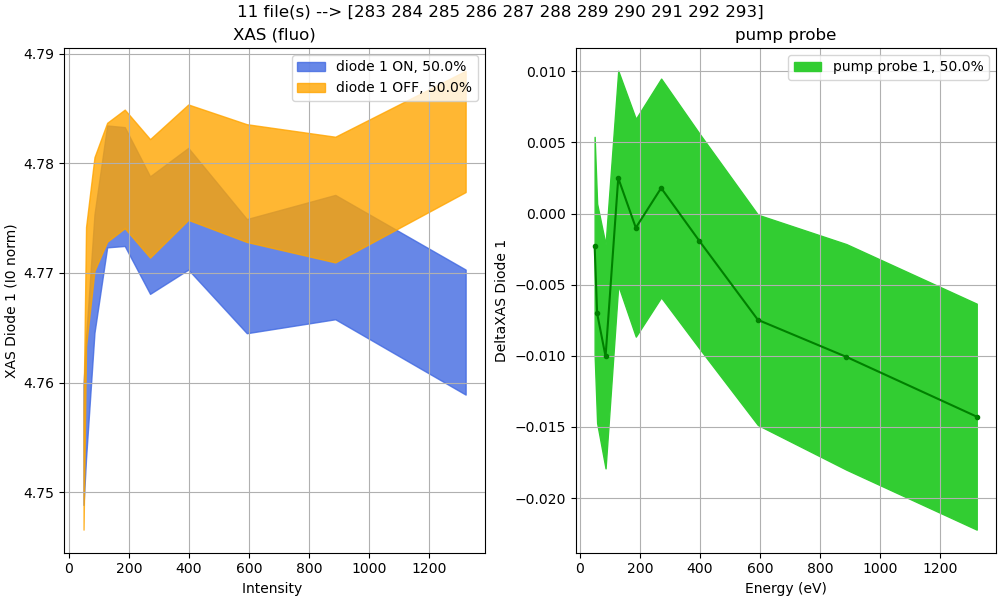

In [246]:
quantile_corr = 0.5

fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(10, 6), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

ff = glob.glob(Loaddir+'/*{:04d}*/XANES_energy_eV.npy'.format(runlist[0]))
waveplate = np.load(ff[0])
intensity = p(waveplate) 

ax1.fill_between(intensity, XAS1_pump - err1_low_pump, XAS1_pump + err1_high_pump , label='diode 1 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
ax1.fill_between(intensity, XAS1_unpump - err1_low_unpump, XAS1_unpump + err1_high_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
ax2.fill_between(intensity, XAS1_pump_probe - err1_low_pump_probe, XAS1_pump_probe + err1_low_pump_probe, label='pump probe 1, {}%'.format(quantile_corr*100),color='limegreen')
ax2.plot(intensity, XAS1_pump_probe, color='green', marker='.')

ax1.set_xlabel("Intensity ")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel ("DeltaXAS Diode 1")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

# Load data

In [237]:
runlist = np.arange(283, 293, 1)
#runlist = [44, 45, 46, 47, 48]
Loaddir = '../Claudio/Reduced_fluencescan/'
##############################################
import glob
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 10 runs: [283 284 285 286 287 288 289 290 291 292] from ../Claudio/Reduced_fluencescan/


['../Claudio/Reduced_fluencescan/run0283-RuRh_ClK_powerscan_2819p7eV_001/run_array.npy',
 '../Claudio/Reduced_fluencescan/run0284-RuRh_ClK_powerscan_2819p7eV_002/run_array.npy',
 '../Claudio/Reduced_fluencescan/run0285-RuRh_ClK_powerscan_2819p7eV_003/run_array.npy',
 '../Claudio/Reduced_fluencescan/run0286-RuRh_ClK_powerscan_2819p7eV_004/run_array.npy',
 '../Claudio/Reduced_fluencescan/run0287-RuRh_ClK_powerscan_2819p7eV_005/run_array.npy',
 '../Claudio/Reduced_fluencescan/run0288-RuRh_ClK_powerscan_2819p7eV_001/run_array.npy',
 '../Claudio/Reduced_fluencescan/run0289-RuRh_ClK_powerscan_2819p7eV_002/run_array.npy',
 '../Claudio/Reduced_fluencescan/run0290-RuRh_ClK_powerscan_2819p7eV_003/run_array.npy',
 '../Claudio/Reduced_fluencescan/run0291-RuRh_ClK_powerscan_2819p7eV_004/run_array.npy',
 '../Claudio/Reduced_fluencescan/run0292-RuRh_ClK_powerscan_2819p7eV_005/run_array.npy']

# Overlay different curves

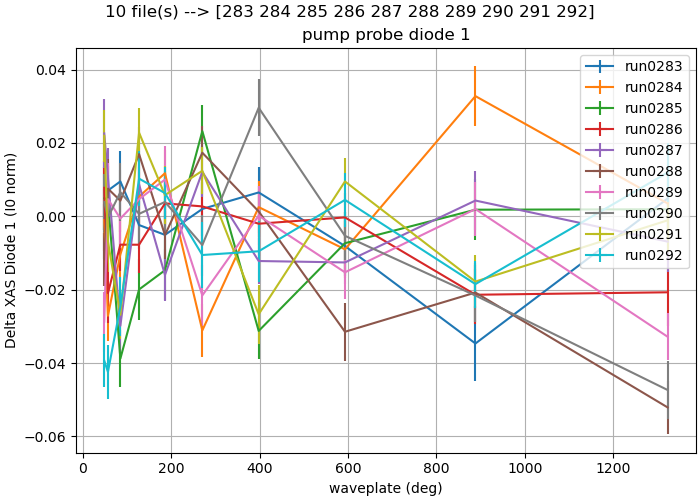

In [238]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []
test=[]

for run in runlist:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        waveplate = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        #intensity = p2 + p3*(2*np.cos(np.pi/180.*(waveplate + p1)))**2                        ## pulse energy (in uJ)
        #intensity = (p2 + p3*(np.cos(2*np.pi/180.*(waveplate - p1)))**2 )*1e-3/(2.45*1e-5)   ## fluence (in mJ/cm2)
        #intensity = yscale*(2*np.cos(np.pi/180.*(waveplate - xshift)))**2
        intensity = p(waveplate)
        
        ax1.axes.errorbar(intensity, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        
        test.append(XAS1_pump_probe[0,0])
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("waveplate (deg)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()


ax1.set_title('pump probe diode 1')

plt.show()

In [218]:
np.mean(np.array(test))

-0.013861834129755524

# Calculate laser fluence 

In [17]:
fluences = 0.20514 +346.78 * (np.cos(np.pi/180*(Waveplate_deg-768.56)))**2

[71.4375 70.0875 68.625  67.275  65.8125 64.4625 63.     61.65   60.3
 58.8375 57.4875]
[294.57418891 300.29098644 306.16636561 311.28353047 316.48180893
 320.95006004 325.42117553 329.19748117 332.62831071 335.9463667
 338.63389868]


<IPython.core.display.Javascript object>


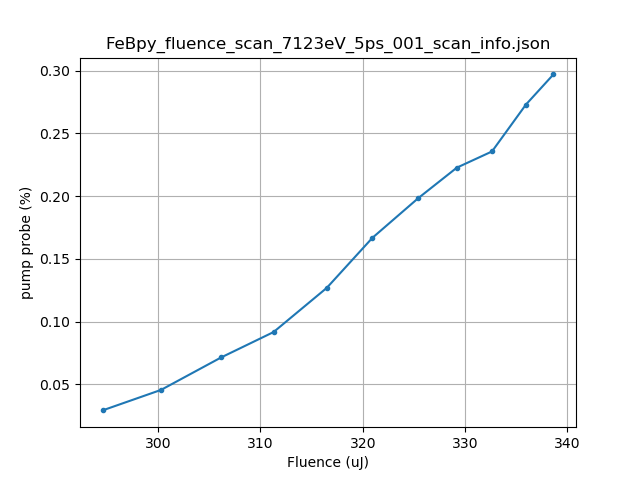

In [20]:
print(Waveplate_deg)
print(fluences)
plt.figure()
plt.title(fc.selected.split('/')[-1])
plt.plot(fluences, XAS_pump_probe/XAS_unpump, marker = '.')
plt.grid()
plt.xlabel('Fluence (uJ)')
plt.ylabel('pump probe (%)')
plt.show()